# 2_CNN_and_Num_Features

In [1]:
import os
os.chdir('/Users/Scott/Desktop/Capstone')

In [2]:
from keras.layers import Input, Convolution2D, Dense, Activation, Flatten,merge
from keras.layers import  MaxPooling2D, Dropout, LocallyConnected2D
from keras.models import Model, load_model
from keras.optimizers import SGD
from lib.data_wrappers import load_train_data,load_test_data
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [3]:
train,validation = load_train_data('train.csv')

In [4]:
test = load_test_data('test.csv')

In [5]:
train_labels = train[2][:]
valid_labels = validation[2][:]

In [6]:
def reformat(labels):
    labels = (np.arange(99) == labels[:,None]).astype(np.float32)
    return labels
train_labels = reformat(train_labels)
valid_labels = reformat(valid_labels)


In [7]:
input_layer = Input(shape=(64,64,1))

In [8]:
#current best, log-loss 0.02312 on leader board
#first
pipe = Convolution2D(8, 3, 3, border_mode='same',W_regularizer='l1')(input_layer)
pipe = (Activation('relu'))(pipe)
pipe = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(pipe)

#second 
pipe = (Convolution2D(16, 3, 3, border_mode='same',W_regularizer='l1'))(pipe)
pipe = (Activation('relu'))(pipe)
pipe = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(pipe)


#flatten
pipe= Flatten()(pipe)

# Define the pre-extracted feature input
num = Input(shape=(192,), name='num')
# Concatenate the output of our convnet with our pre-extracted feature input
combined = merge([pipe, num], mode='concat')

#fully connected layer
combined = Dense(100, activation='relu')(combined)
combined = Dropout(.5)(combined)

#output layer
output_layer = Dense(99, activation='softmax')(combined)

In [9]:
sgd = SGD(lr=0.008, momentum=0.9,decay=0.0,nesterov=False)

In [10]:
# for image + numerical data
model = Model(input=[input_layer,num],output=output_layer)

In [11]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# for image+ numerical data
history = model.fit([train[1][:],train[0][:]],train_labels,
                   validation_data=([validation[1][:],validation[0][:]],valid_labels),
                   nb_epoch=1)

Train on 792 samples, validate on 99 samples
Epoch 1/1
792/792 [==============================] - 0s - loss: 0.0836 - acc: 0.9949 - val_loss: 0.0636 - val_acc: 1.0000


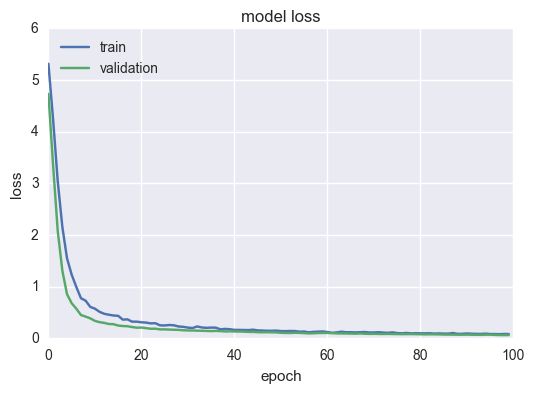

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

### Max Validation Accuracy = 1.00
### Min Validation Loss = 0.02312 * after 300 epochs

### Notes

Overfitting is apparent after ~300 epochs (not shown), as the training loss decreases while the validation loss rises. Accurracy is perfect on the validation set, and the Log-Loss on kaggle's test set was 0.02312 after 300 epochs  making this by far the best model.